### 1. Load packages

In [1]:
import time

In [3]:
!pip install tinkoff-investments


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [5]:
TOKEN = '' #боевой M13

In [6]:
from tinkoff.invest import Client
#from tinkoff.invest.constants import INVEST_GRPC_API_SANDBOX 


# with Client(TOKEN, target=INVEST_GRPC_API_SANDBOX ) as client:
#     print(client.users.get_accounts())


with Client(TOKEN) as client:
    print(client.users.get_accounts())

GetAccountsResponse(accounts=[Account(id='2169433725', type=<AccountType.ACCOUNT_TYPE_TINKOFF: 1>, name='M13', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2022, 4, 27, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_READ_ONLY: 2>)])


### 2. Load data

In [14]:
import logging
import os

import pandas as pd

from tinkoff.invest import Client, SecurityTradingStatus
from tinkoff.invest.services import InstrumentsService
from tinkoff.invest.utils import quotation_to_decimal



In [17]:
def get_figi(ticker):
    with Client(TOKEN) as client:
        instruments: InstrumentsService = client.instruments
        tickers = []
        for method in ["shares", "bonds", "etfs", "currencies", "futures"]:
            for item in getattr(instruments, method)().instruments:
                tickers.append(
                    {
                        "name": item.name,
                        "ticker": item.ticker,
                        "class_code": item.class_code,
                        "figi": item.figi,
                        "uid": item.uid,
                        "type": method,
                        "min_price_increment": quotation_to_decimal(
                            item.min_price_increment
                        ),
                        "scale": 9 - len(str(item.min_price_increment.nano)) + 1,
                        "lot": item.lot,
                        "trading_status": str(
                            SecurityTradingStatus(item.trading_status).name
                        ),
                        "api_trade_available_flag": item.api_trade_available_flag,
                        "currency": item.currency,
                        "exchange": item.exchange,
                        "buy_available_flag": item.buy_available_flag,
                        "sell_available_flag": item.sell_available_flag,
                        "short_enabled_flag": item.short_enabled_flag,
                        "klong": quotation_to_decimal(item.klong),
                        "kshort": quotation_to_decimal(item.kshort),
                    }
                )

        tickers_df = pd.DataFrame(tickers)

        ticker_df = tickers_df[tickers_df["ticker"] == ticker]
        #return ticker_df
        if ticker_df.empty:
            print("There is no such ticker: %s", ticker)
            return

        figi = ticker_df["figi"].iloc[0]
        return figi

In [20]:
import os
from datetime import timedelta
import datetime

from tqdm import tqdm
import numpy as np

from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.utils import now

    
def get_all_candles(ticker=None, from_=None, to_=None, interval=None):
    
    figi = get_figi(ticker)
    
    with Client(TOKEN) as client:
        
        data = [elem for elem in client.get_all_candles(figi=figi, 
                                      from_=from_-timedelta(hours=3),
                                      to=to_- timedelta(hours=3),
                                     interval=interval
                                    )
               ]

    
    open_ = np.zeros(len(data))
    high = np.zeros(len(data))
    low = np.zeros(len(data))
    close = np.zeros(len(data))
    volume = np.zeros(len(data))
    time = np.zeros(len(data), dtype='O')
    for i, elem in enumerate(data):
        open_[i] = quotation_to_decimal(elem.open)
        high[i] = quotation_to_decimal(elem.high)
        low[i] = quotation_to_decimal(elem.low)
        close[i] = quotation_to_decimal(elem.close)
        volume[i] = elem.volume
        time[i] = elem.time


    df = pd.DataFrame({'time' : time,
                      'open' : open_,
                      'close' : close,
                      'volume' : volume,
                      'low' : low,
                      'high' : high
                    })
    df['time'] += pd.Timedelta(hours=3)
    return df

### -1


In [24]:
get_figi('SFIN')

'BBG003LYCMB1'

In [26]:
ticker = 'T'
#2024-06-10 
data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2024, 6, 10, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 6, 12, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )

data['ticker'] = ticker
data

,time,open,close,volume,low,high,ticker
0,2024-06-10 09:00:00+00:00,2974.0,2974.0,1846.0,2974.0,2974.0,T
1,2024-06-10 10:00:00+00:00,2972.6,2989.0,252336.0,2970.0,2999.0,T
2,2024-06-10 11:00:00+00:00,2989.0,2976.0,106799.0,2972.0,2992.0,T
3,2024-06-10 12:00:00+00:00,2976.0,2977.6,139763.0,2962.6,2980.0,T
4,2024-06-10 13:00:00+00:00,2976.0,2973.6,64276.0,2970.0,2983.0,T
5,2024-06-10 14:00:00+00:00,2973.6,2974.0,66350.0,2966.0,2982.6,T
6,2024-06-10 15:00:00+00:00,2972.6,2948.6,133118.0,2945.0,2973.6,T
7,2024-06-10 16:00:00+00:00,2948.6,2947.0,69133.0,2943.0,2955.0,T
8,2024-06-10 17:00:00+00:00,2947.6,2930.6,86918.0,2926.6,2949.6,T
9,2024-06-10 18:00:00+00:00,2930.0,2898.0,161966.0,2890.0,2932.6,T


In [27]:
data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2024, 6, 10, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 6, 12, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_DAY
                      )

data['ticker'] = ticker
data

,time,open,close,volume,low,high,ticker
0,2024-06-10 03:00:00+00:00,2974.0,2886.6,1391052.0,2851.0,2999.0,T
1,2024-06-11 03:00:00+00:00,2893.6,2890.6,1160771.0,2850.0,2909.0,T


### -1

In [33]:
%%time

ticker = 'TMOS'

data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2025, 1, 1, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2025, 1, 10, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )

data['ticker'] = ticker

CPU times: user 832 ms, sys: 26.1 ms, total: 858 ms
Wall time: 2.25 s


In [35]:
data

,time,open,close,volume,low,high,ticker
0,2025-01-03 09:00:00+00:00,6.31,6.31,81165.0,6.31,6.31,TMOS
1,2025-01-03 10:00:00+00:00,6.30,6.20,12405231.0,6.20,6.31,TMOS
2,2025-01-03 11:00:00+00:00,6.20,6.19,4224743.0,6.16,6.22,TMOS
3,2025-01-03 12:00:00+00:00,6.19,6.14,5029243.0,6.12,6.19,TMOS
4,2025-01-03 13:00:00+00:00,6.14,6.14,4735730.0,6.12,6.17,TMOS
5,2025-01-03 14:00:00+00:00,6.14,6.14,6350496.0,6.10,6.15,TMOS
6,2025-01-03 15:00:00+00:00,6.15,6.14,1389740.0,6.13,6.16,TMOS
7,2025-01-03 16:00:00+00:00,6.14,6.14,2190425.0,6.12,6.15,TMOS
8,2025-01-03 17:00:00+00:00,6.14,6.15,2098042.0,6.13,6.16,TMOS
9,2025-01-03 18:00:00+00:00,6.15,6.15,695071.0,6.14,6.15,TMOS


In [38]:
!mkdir data

mkdir: data: File exists


In [40]:
!mkdir data/raw

mkdir: data/raw: File exists


In [42]:
!mkdir data/raw/1hour

mkdir: data/raw/1hour: File exists


In [44]:
!mkdir data/raw/1day

mkdir: data/raw/1day: File exists


In [48]:
import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### Рынок РФ акций

In [52]:
df_stocks = pd.read_csv('russian_market_v2.csv', delimiter=';')
df_stocks

,Торговый код ценной бумаги,Краткое наименование эмитента ценной бумаги,"Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)",Государственный\r\nрегистрационный\r\nномер выпуска\r\n(дополнительного\r\nвыпуска)*,"Объем выпуска, штук","Рыночная цена (3) на 30.09.2024, руб.","Капитализация, руб.",Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,ABIO,"ПАО ""Артген""",ао,1-01-08902-A,92 645 451,"100,96","9 353 484 732,96",NaN,NaN,NaN,NaN
1,ABRD,"ПАО ""Абрау – Дюрсо""",ао,1-02-12500-A,98 000 184,214,"20 972 039 376,00",NaN,NaN,NaN,NaN
2,ACKO,"ПАО ""АСКО""",ао,1-01-52065-Z,536 000 000,NaN,NaN,NaN,NaN,NaN,NaN
3,AFKS,"ПАО АФК ""СИСТЕМА""",ао,1-05-01669-A,9 650 000 000,"16,558","159 784 700 000,00",NaN,NaN,NaN,NaN
4,AFLT,"ПАО ""Аэрофлот""",ао,1-01-00010-A,3 975 771 215,"55,13","219 184 267 082,95",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
247,YRSB,"ПАО ""ТНС энерго Ярославль""",ао,1-01-50099-A,17 143 584,882,"15 120 641 088,00",NaN,NaN,NaN,NaN
248,YRSBP,"ПАО ""ТНС энерго Ярославль""",ап,2-01-50099-A,4 507 320,"199,5","899 210 340,00",NaN,NaN,NaN,NaN
249,ZAYM,"ПАО МФК ""Займер""",ао,1-01-16767-A,100 000 000,"180,3","18 030 000 000,00",NaN,NaN,NaN,NaN
250,ZILL,АМО ЗИЛ,ао,1-02-00036-A,2 659 962,3180,"8 458 679 160,00",NaN,NaN,NaN,NaN


In [54]:
df_stocks['cap'] = df_stocks['Капитализация, руб.'].apply(lambda x: float(str(x).replace("\xa0", "").replace(",", "."))) / 1e9
df_stocks.sort_values(by='cap', inplace=True)
df_stocks

,Торговый код ценной бумаги,Краткое наименование эмитента ценной бумаги,"Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)",Государственный\r\nрегистрационный\r\nномер выпуска\r\n(дополнительного\r\nвыпуска)*,"Объем выпуска, штук","Рыночная цена (3) на 30.09.2024, руб.","Капитализация, руб.",Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,cap
200,SVETP,"ПАО ""Светофор Групп""",ап,2-01-24350-J,2 481 500,"30,95","76 802 425,00",NaN,NaN,NaN,NaN,0.076802
202,TASBP,"ПАО ""Тамбовская энергосбытовая компания""",ап,2-01-65100-D,217 961 420,"0,87","189 626 435,40",NaN,NaN,NaN,NaN,0.189626
74,KCHEP,"ПАО ""Камчатскэнерго""",ап,2-02-00235-A,183 062 052,"1,075","196 791 705,90",NaN,NaN,NaN,NaN,0.196792
212,TORSP,"ПАО ""Россети Томск""",ап,2-01-50128-A,576 693 000,"0,442","254 898 306,00",NaN,NaN,NaN,NaN,0.254898
208,TGKBP,"ПАО ""ТГК-2""",ап,2-01-10420-A,16 500 533 681,"0,01547","255 263 256,05",NaN,NaN,NaN,NaN,0.255263
...,...,...,...,...,...,...,...,...,...,...,...,...
2,ACKO,"ПАО ""АСКО""",ао,1-01-52065-Z,536 000 000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,GAZC,"ПАО ""ГАЗКОН""",ао,1-01-09870-A,225 381 601,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,GAZS,"ПАО ""ГАЗ-сервис""",ао,1-01-09871-A,206 508 967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,GAZT,"ПАО ""ГАЗ-Тек""",ао,1-01-12996-A,471 428 300,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df_stocks['cap'].quantile(q=np.arange(0.1, 1, 0.1))

0.1      1.087725
0.2      2.604548
0.3      5.904478
0.4     13.136967
0.5     20.972039
0.6     44.223992
0.7     68.811818
0.8    159.531385
0.9    418.254119
Name: cap, dtype: float64

In [58]:
#большинство более 1 млрд капы имеют, норм

In [60]:
#самые дорогие
df_stocks.iloc[-10:]

,Торговый код ценной бумаги,Краткое наименование эмитента ценной бумаги,"Категория ценной бумаги (ао - акция обыкновенная, ап - акция привилегированная)",Государственный\r\nрегистрационный\r\nномер выпуска\r\n(дополнительного\r\nвыпуска)*,"Объем выпуска, штук","Рыночная цена (3) на 30.09.2024, руб.","Капитализация, руб.",Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,cap
49,GAZP,"ПАО ""Газпром""",ао,1-02-00028-A,23 673 512 900,"140,99","3 337 728 583 771,00",NaN,NaN,NaN,NaN,3337.728584
188,SIBN,"ПАО ""Газпром нефть""",ао,1-01-00146-A,4 741 299 639,"709,3","3 363 003 833 942,70",NaN,NaN,NaN,NaN,3363.003834
96,LKOH,"ПАО ""ЛУКОЙЛ""",ао,1-01-00077-A,692 865 762,6936,"4 805 716 925 232,00",NaN,NaN,NaN,NaN,4805.716925
169,ROSN,"ПАО ""НК ""Роснефть""",ао,1-02-00122-A,10 598 177 817,"510,8","5 413 549 228 923,60",NaN,NaN,NaN,NaN,5413.549229
183,SBER,ПАО Сбербанк,ао,10301481B,21 586 948 000,"270,8","5 845 745 518 400,00",NaN,NaN,NaN,NaN,5845.745518
2,ACKO,"ПАО ""АСКО""",ао,1-01-52065-Z,536 000 000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,GAZC,"ПАО ""ГАЗКОН""",ао,1-01-09870-A,225 381 601,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,GAZS,"ПАО ""ГАЗ-сервис""",ао,1-01-09871-A,206 508 967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,GAZT,"ПАО ""ГАЗ-Тек""",ао,1-01-12996-A,471 428 300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,MGNZ,"ОАО ""СМЗ""",ао,1-01-00283-A,398 272,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Пропингуем доступные акции

In [64]:
all_stocks = df_stocks['Торговый код ценной бумаги'].tolist()
all_stocks

['SVETP',
 'TASBP',
 'KCHEP',
 'TORSP',
 'TGKBP',
 'DZRDP',
 'BISVP',
 'SAREP',
 'MAGEP',
 'CNTLP',
 'SVET',
 'VSYDP',
 'GAZAP',
 'MISBP',
 'YKENP',
 'LNZLP',
 'KGKCP',
 'STSBP',
 'VGSBP',
 'KUZB',
 'YRSBP',
 'KROTP',
 'KRKOP',
 'MRSB',
 'BSPBP',
 'DIOD',
 'VLHZ',
 'DZRD',
 'NNSBP',
 'ARSA',
 'WTCMP',
 'IGSTP',
 'SAGOP',
 'MAGE',
 'LIFE',
 'ASSB',
 'RTSBP',
 'CNTL',
 'LVHK',
 'KAZTP',
 'ROST',
 'TUZA',
 'GEMA',
 'KRKNP',
 'KRSBP',
 'KLSB',
 'SARE',
 'TASB',
 'STSB',
 'KZOSP',
 'TORS',
 'GECO',
 'NFAZ',
 'VRSBP',
 'CHGZ',
 'MGKL',
 'UNKL',
 'PMSBP',
 'NKSH',
 'RDRB',
 'JNOSP',
 'RTGZ',
 'VGSB',
 'KLVZ',
 'SLEN',
 'ZVEZ',
 'PRFN',
 'KMEZ',
 'CARM',
 'RBCM',
 'YKEN',
 'HIMCP',
 'KGKC',
 'NSVZ',
 'NAUK',
 'MRKZ',
 'RZSB',
 'IGST',
 'MISB',
 'PRMB',
 'EELT',
 'KRKN',
 'MFGSP',
 'KRSB',
 'KBSB',
 'ZILL',
 'PMSB',
 'ABIO',
 'RUSI',
 'MRKY',
 'SAGO',
 'BELU',
 'KOGK',
 'VJGZP',
 'LPSB',
 'APRI',
 'MRKV',
 'GAZA',
 'TGKB',
 'BRZL',
 'LNZL',
 'URKZ',
 'RTKMP',
 'WTCM',
 'YRSB',
 'TTLK',
 'CHKZ',

In [67]:
stocks = []

pbar = tqdm(total=len(all_stocks))

i = 0
while i < len(all_stocks):
    ticker = all_stocks[i]
    try:
        data = get_all_candles(ticker=ticker,
                           from_=datetime.datetime(2025, 1, 1, tzinfo=datetime.timezone.utc),
                           to_=datetime.datetime(2025, 1, 10, tzinfo=datetime.timezone.utc),
                           interval=CandleInterval.CANDLE_INTERVAL_DAY
                          )

        stocks += [ticker]
        i+=1
        pbar.update(1)
        
    except Exception as exception:
        if exception.code.name == 'INVALID_ARGUMENT':
            i+=1
            pbar.update(1)
        else:
            time.sleep(5)

pbar.close()   

  0%|▎                                                                        | 1/252 [00:03<13:24,  3.20s/it]

There is no such ticker: %s SVETP


7cce43d37799593ad9b752b5fd9e228b GetCandles INVALID_ARGUMENT 30093
  1%|▌                                                                        | 2/252 [00:06<12:37,  3.03s/it]

There is no such ticker: %s TASBP
There is no such ticker: %s KCHEP


19eacdb41ba084e3ce3b8e15c6ed0c76 GetCandles INVALID_ARGUMENT 30093
  1%|▊                                                                        | 3/252 [00:09<13:00,  3.13s/it]

There is no such ticker: %s TORSP


b065e29bfb8d42a5e895090b7d96c124 GetCandles INVALID_ARGUMENT 30093
  2%|█▋                                                                       | 6/252 [00:18<12:18,  3.00s/it]

There is no such ticker: %s DZRDP


a8db9a78b66847b0b50f8044fd48d354 GetCandles INVALID_ARGUMENT 30093
  3%|██                                                                       | 7/252 [00:21<12:06,  2.97s/it]

There is no such ticker: %s BISVP


0aaec0bc3f9ba92f41cd55f9fbe6bbe3 GetCandles INVALID_ARGUMENT 30093
  3%|██▎                                                                      | 8/252 [00:24<11:56,  2.93s/it]

There is no such ticker: %s SAREP


KeyboardInterrupt: 

In [113]:
len(stocks)

149

In [ ]:
stocks

In [51]:
stocks = [

    'TGKBP',
 'CNTLP',
 'LNZLP',
 'DIOD',
 'LIFE',
 'CNTL',
 'KAZTP',
 'ROST',
 'KRKNP',
 'KLSB',
 'KZOSP',
 'GECO',
 'MGKL',
 'UNKL',
 'PMSBP',
 'KLVZ',
 'PRFN',
 'CARM',
 'RBCM',
 'NSVZ',
 'MRKZ',
 'PMSB',
 'ABIO',
 'MRKY',
 'BELU',
 'MRKV',
 'TGKB',
 'LNZL',
 'RTKMP',
 'TTLK',
 'TGKN',
 'NKNCP',
 'MGTSP',
 'MRKC',
 'SPBE',
 'MTLRP',
 'ZAYM',
 'LSNGP',
 'GTRK',
 'KROT',
 'CHMK',
 'MVID',
 'ELFV',
 'ABRD',
 'ROLO',
 'IVAT',
 'WUSH',
 'EUTR',
 'BLNG',
 'SGZH',
 'SVAV',
 'HNFG',
 'VRSB',
 'TGKA',
 'MRKU',
 'RKKE',
 'MRKP',
 'BANEP',
 'DELI',
 'OGKB',
 'SOFL',
 'DVEC',
 "VEON-RX",#'X5',
 'RNFT',
 'AMEZ',
 'MSTT',
 'MTLR',
 'RENI',
 'NKHP',
 'MRKS',
 'DIAS',
 'YAKG',
 'AQUA',
 'GEMC',
 'MBNK',
 'MSRS',
 'SELG',
 'INGR',
 'VSEH',
 'SFIN',
 'MDMG',
 'LSRG',
 'PRMD',
 'LEAS',
 'VKCO',
 'ELMT',
 'APTK',
 'KMAZ',
 'TATNP',
 'MSNG',
 'UPRO',
 'ASTR',
 'KAZT',
 'SMLT',
 'TRMK',
 'LSNG',
 'LENT',
 'NKNC',
 'FESH',
 'KZOS',
 'AFKS',
 'UWGN',
 'HEAD',
 'UGLD',
 'NMTP',
 'BSPB',
 'POSI',
 'FEES',
 'GCHE',
 'RASP',
 'TRNFP',
 'CBOM',
 'AFLT',
 'ENPG',
 'FLOT',
 'HYDR',
 'RTKM',
 'SBERP',
 'SVCB',
 'VSMO',
 'BANE',
 'IRAO',
 'ALRS',
 'MTSS',
 'SNGSP',
 'PIKK',
 'VTBR',
 'MOEX',
 'MAGN',
 'RUAL',
 'T',
 'MGNT',
 'AKRN',
 'IRKT',
 'PHOR',
 'UNAC',
 'NLMK',
 'SNGS',
 'CHMF',
 'TATN',
 'YDEX',
 'GMKN',
 'PLZL',
 'NVTK',
 'GAZP',
 'SIBN',
 'LKOH',
 'ROSN',
 'SBER']

start = datetime.datetime(2022, 5, 1, tzinfo=datetime.timezone.utc)
end = datetime.datetime(2025, 2, 5, tzinfo=datetime.timezone.utc)

In [53]:
#1hour
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:
            data = get_all_candles(ticker=stock,
                       from_=start,
                       to_=end,
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(5)

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1hour/{stock}.pkl")

  3%|██▍                                                                      | 5/149 [01:04<31:15, 13.03s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


  6%|████▍                                                                    | 9/149 [02:11<34:21, 14.73s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


  9%|██████▎                                                                 | 13/149 [03:08<30:40, 13.54s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 11%|████████▏                                                               | 17/149 [04:12<30:56, 14.07s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 14%|██████████▏                                                             | 21/149 [05:08<28:43, 13.46s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 17%|████████████                                                            | 25/149 [06:05<27:21, 13.23s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 19%|██████████████                                                          | 29/149 [07:09<28:02, 14.02s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 22%|███████████████▉                                                        | 33/149 [08:09<26:37, 13.77s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 25%|█████████████████▉                                                      | 37/149 [09:06<24:57, 13.37s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 28%|███████████████████▊                                                    | 41/149 [10:10<24:57, 13.87s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 30%|█████████████████████▋                                                  | 45/149 [11:10<24:18, 14.02s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 33%|███████████████████████▋                                                | 49/149 [12:03<21:24, 12.85s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 36%|█████████████████████████▌                                              | 53/149 [13:06<21:38, 13.52s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 38%|███████████████████████████▌                                            | 57/149 [14:11<21:55, 14.29s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 41%|█████████████████████████████▍                                          | 61/149 [15:08<19:37, 13.38s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 44%|███████████████████████████████▍                                        | 65/149 [16:13<20:06, 14.37s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 46%|█████████████████████████████████▎                                      | 69/149 [17:13<18:39, 14.00s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 49%|███████████████████████████████████▎                                    | 73/149 [18:09<16:56, 13.37s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 52%|█████████████████████████████████████▏                                  | 77/149 [19:07<16:19, 13.60s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 54%|███████████████████████████████████████▏                                | 81/149 [20:13<16:13, 14.31s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 57%|█████████████████████████████████████████                               | 85/149 [21:10<14:38, 13.73s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 60%|███████████████████████████████████████████                             | 89/149 [22:06<13:23, 13.40s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 62%|████████████████████████████████████████████▉                           | 93/149 [23:15<13:30, 14.48s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 68%|████████████████████████████████████████████████▏                      | 101/149 [25:10<10:38, 13.30s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 70%|██████████████████████████████████████████████████                     | 105/149 [26:07<09:51, 13.45s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 73%|███████████████████████████████████████████████████▉                   | 109/149 [27:11<09:38, 14.45s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 81%|█████████████████████████████████████████████████████████▏             | 120/149 [30:03<06:53, 14.27s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 86%|████████████████████████████████████████████████████████████▉          | 128/149 [32:15<05:14, 15.00s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 91%|████████████████████████████████████████████████████████████████▎      | 135/149 [34:06<03:29, 15.00s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


 99%|██████████████████████████████████████████████████████████████████████ | 147/149 [37:11<00:27, 13.97s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


100%|███████████████████████████████████████████████████████████████████████| 149/149 [37:49<00:00, 15.23s/it]


In [55]:
#1day
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:
            data = get_all_candles(ticker=stock,
                               from_=start,
                               to_=end,
                               interval=CandleInterval.CANDLE_INTERVAL_DAY)
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(5)

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1day/{stock}.pkl")

100%|███████████████████████████████████████████████████████████████████████| 149/149 [06:16<00:00,  2.53s/it]


### IMOEX

In [60]:
#1hour

stock = "TMOS"

data = get_all_candles(ticker=stock,
                       from_=start,
                       to_=end,
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )
data['ticker'] = stock
dump_pkl(data, f"./data/raw/1hour/{stock}.pkl")



#1day
data = get_all_candles(ticker=stock,
                       from_=start,
                       to_=end,
                       interval=CandleInterval.CANDLE_INTERVAL_DAY
                      )
data['ticker'] = stock
dump_pkl(data, f"./data/raw/1day/{stock}.pkl")


### 3. Посмотрим на объемы торгов во времени

#### 3.1 По дням

In [67]:
path = './data/raw/1day/SBER.pkl'
df = load_pkl(path)
df['time'] = df['time'].apply(lambda x: x.tz_convert(None))

df

,time,open,close,volume,low,high,ticker
0,2022-05-04 03:00:00,129.10,123.20,6728890.0,122.50,131.50,SBER
1,2022-05-05 03:00:00,124.21,124.80,4238300.0,122.75,125.54,SBER
2,2022-05-06 03:00:00,124.74,123.10,3060250.0,121.52,124.99,SBER
3,2022-05-11 03:00:00,123.00,123.34,3287044.0,121.86,126.05,SBER
4,2022-05-12 03:00:00,123.10,119.15,3084646.0,118.05,123.74,SBER
...,...,...,...,...,...,...,...
696,2025-01-29 03:00:00,278.00,280.36,3916163.0,277.12,282.18,SBER
697,2025-01-30 03:00:00,280.44,281.97,2802072.0,280.36,282.50,SBER
698,2025-01-31 03:00:00,281.97,280.73,4032660.0,280.27,284.11,SBER
699,2025-02-03 03:00:00,280.21,279.55,3037066.0,278.00,280.35,SBER


In [68]:
start = pd.Timestamp('2024-10-1')
end = pd.Timestamp('2024-10-31')

mask = (start <= df['time']) & (df['time'] < end)
mask.sum()

22

In [69]:
df_month= df.loc[mask, :]
df_month = df_month.set_index('time')
df_month

,open,close,volume,low,high,ticker
time,,,,,,
2024-10-01 03:00:00,267.60,266.29,5212580.0,264.00,268.68,SBER
2024-10-02 03:00:00,266.01,259.31,4651920.0,258.52,268.00,SBER
2024-10-03 03:00:00,259.31,264.25,5653456.0,257.20,264.49,SBER
2024-10-04 03:00:00,264.96,264.09,2599229.0,262.11,265.44,SBER
2024-10-07 03:00:00,264.25,263.39,2894060.0,261.37,267.00,SBER
2024-10-08 03:00:00,263.00,262.40,1616378.0,261.89,263.80,SBER
2024-10-09 03:00:00,262.42,260.86,2502135.0,259.59,263.80,SBER
2024-10-10 03:00:00,260.88,259.98,1767723.0,258.91,261.64,SBER
2024-10-11 03:00:00,259.80,256.94,2484858.0,256.80,260.07,SBER


<Axes: xlabel='time'>

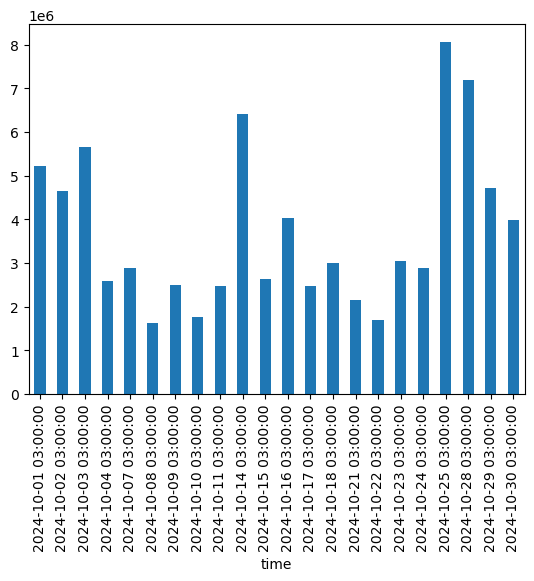

In [70]:
import matplotlib.pyplot as plt

#df_day['close'].plot()
df_month['volume'].plot.bar()
#plt.xticks(pd.date_range(start, end, freq='D'))

In [71]:
#Выходных нет, это хорошо, так как они внутри тинька идут, а не на биржи

### 4. Preproc data

* Оставляем только будни
* И часы основных торгов - 10:00–23
* Добавим к акциям IMOEX

In [78]:
!mkdir data/preproc

mkdir: data/preproc: File exists


In [79]:
!mkdir data/preproc/1hour

mkdir: data/preproc/1hour: File exists


In [80]:
!mkdir data/preproc/1day

mkdir: data/preproc/1day: File exists


In [85]:
stock = "TMOS"
data_tmos = load_pkl(f"./data/raw/1hour/{stock}.pkl")
data_tmos

,time,open,close,volume,low,high,ticker
0,2022-05-04 09:00:00+00:00,4.31,4.31,4415.0,4.31,4.31,TMOS
1,2022-05-04 10:00:00+00:00,4.31,4.27,3639437.0,4.24,4.40,TMOS
2,2022-05-04 11:00:00+00:00,4.27,4.20,5241412.0,4.19,4.29,TMOS
3,2022-05-04 12:00:00+00:00,4.20,4.22,897694.0,4.19,4.22,TMOS
4,2022-05-04 13:00:00+00:00,4.22,4.21,1120045.0,4.20,4.23,TMOS
...,...,...,...,...,...,...,...
10031,2025-02-04 19:00:00+00:00,6.38,6.40,979766.0,6.38,6.40,TMOS
10032,2025-02-04 20:00:00+00:00,6.40,6.39,371384.0,6.38,6.40,TMOS
10033,2025-02-04 21:00:00+00:00,6.39,6.36,1580734.0,6.36,6.39,TMOS
10034,2025-02-04 22:00:00+00:00,6.37,6.38,500139.0,6.36,6.38,TMOS


In [86]:
#1 hour

def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

def preproc(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    mask_volume = np.array(datetime.time(10, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data
    


#1hour
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1hour/{stock}.pkl")

    data_ext = data.merge(data_tmos[['time', 'close']].copy().rename(columns={"close" : "tmos_close"}), how='left', on='time')
    assert data.shape[0] == data_ext.shape[0], 'Error 1'

    data = preproc(data_ext)
    assert data['tmos_close'].isnull().sum() < 500, 'Error 2'

    data['tmos_close'] = data['tmos_close'].ffill()
    
    dump_pkl(data, f"./data/preproc/1hour/{stock}.pkl")

100%|███████████████████████████████████████████████████████████████████████| 149/149 [00:17<00:00,  8.45it/s]


In [89]:
stock = "TMOS"
data_tmos = load_pkl(f"./data/raw/1day/{stock}.pkl")
data_tmos

,time,open,close,volume,low,high,ticker
0,2022-05-04 03:00:00+00:00,4.31,4.18,14090097.0,4.18,4.40,TMOS
1,2022-05-05 03:00:00+00:00,4.21,4.22,9804905.0,4.19,4.26,TMOS
2,2022-05-06 03:00:00+00:00,4.23,4.19,7532579.0,4.16,4.24,TMOS
3,2022-05-11 03:00:00+00:00,4.26,4.22,10235590.0,4.18,4.30,TMOS
4,2022-05-12 03:00:00+00:00,4.20,4.06,9508900.0,4.02,4.24,TMOS
...,...,...,...,...,...,...,...
696,2025-01-29 03:00:00+00:00,6.41,6.42,20318201.0,6.38,6.46,TMOS
697,2025-01-30 03:00:00+00:00,6.44,6.49,19160764.0,6.43,6.49,TMOS
698,2025-01-31 03:00:00+00:00,6.51,6.48,30477788.0,6.44,6.54,TMOS
699,2025-02-03 03:00:00+00:00,6.45,6.45,23701442.0,6.38,6.45,TMOS


In [90]:
#1 day

def preproc_day_data(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    #mask_volume = np.array(datetime.time(10, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    #data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data



for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1day/{stock}.pkl")

    data_ext = data.merge(data_tmos[['time', 'close']].copy().rename(columns={"close" : "tmos_close"}), how='left', on='time')
    assert data.shape[0] == data_ext.shape[0], 'Error 1'
    
    data = preproc_day_data(data_ext)
    
    assert data['tmos_close'].isnull().sum() < 25, 'Error 2' #праздники, в них индекс не торгуется
    data['tmos_close'] = data['tmos_close'].ffill()
    
    dump_pkl(data, f"./data/preproc/1day/{stock}.pkl")

  0%|                                                                                 | 0/149 [00:00<?, ?it/s]/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93874/3988053929.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tmos_close'] = data['tmos_close'].ffill()
/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93874/3988053929.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tmos_close'] = data['tmos_close'].ffill()
/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T

### 5. Анализ на целостность данных

#### 5.3 1hour

In [97]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    assert df.notnull().all().all(), f'{stock} nulls'
    

100%|██████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 921.44it/s]


In [98]:
#Нет дублей и данные отсортированы, нет null's

In [100]:
#Заполняемость

In [101]:


dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('1 hour')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|█████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 1919.54it/s]


(1082756, 9)

<Axes: xlabel='diff'>

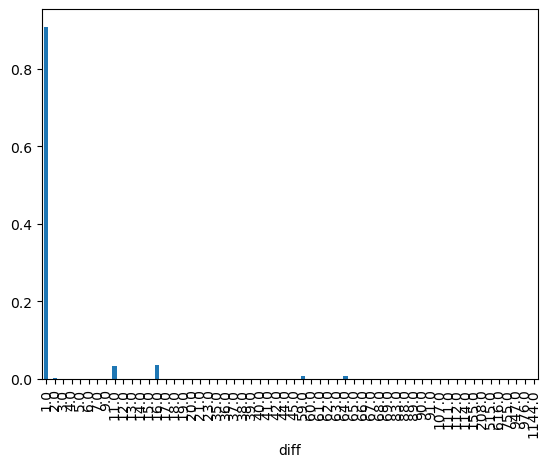

In [102]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [103]:
((df['diff'] < 2) | (df['diff'] == 11) | (df['diff'] == 16) | (df['diff'] == 59)).mean()

0.9841127640945883

In [104]:
#Отлично (не все выходные еще учтены)

#### 5.4 1day

In [108]:
for stock in tqdm(stocks):
    
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

    #print(stock)
    # assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    # assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    # assert df.notnull().all().all(), f'{stock} nulls'

    if not (df['time'].sort_values()  == df['time']).all():
        print(f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}')
        
    if df['time'].duplicated().any():
        print(f'{stock} duplicated: {df['time'].duplicated().sum()}')
        
    if not df.notnull().all().all():
        print(f'{stock} nulls: {df.isnull().sum()}')

100%|█████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 2753.49it/s]

DIOD nulls: time          0
open          0
close         0
volume        0
low           0
high          0
ticker        0
tmos_close    2
dtype: int64
ROST nulls: time          0
open          0
close         0
volume        0
low           0
high          0
ticker        0
tmos_close    2
dtype: int64
INGR nulls: time          0
open          0
close         0
volume        0
low           0
high          0
ticker        0
tmos_close    2
dtype: int64


In [109]:
stock = "DIOD"
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df

,time,open,close,volume,low,high,ticker,tmos_close
0,2022-05-02 03:00:00,73.59,75.94,207800.0,73.04,76.10,DIOD,NaN
1,2022-05-03 03:00:00,76.00,76.25,255000.0,75.06,77.23,DIOD,NaN
2,2022-05-04 03:00:00,76.52,80.44,359100.0,75.49,80.77,DIOD,4.18
3,2022-05-05 03:00:00,81.80,76.07,360600.0,74.71,81.80,DIOD,4.22
4,2022-05-06 03:00:00,75.10,75.37,313900.0,73.53,76.97,DIOD,4.19
...,...,...,...,...,...,...,...,...
688,2025-01-29 03:00:00,57.62,57.40,413000.0,57.05,58.22,DIOD,6.42
689,2025-01-30 03:00:00,58.01,58.41,355400.0,57.49,59.08,DIOD,6.49
690,2025-01-31 03:00:00,58.38,58.98,543400.0,57.79,60.19,DIOD,6.48
691,2025-02-03 03:00:00,57.20,56.45,364500.0,55.85,58.05,DIOD,6.45


In [113]:
#Нет дублей и данные отсортированы

In [115]:
#Заполняемость

In [116]:
dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('24 hours')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|█████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 4044.52it/s]


(95387, 9)

<Axes: xlabel='diff'>

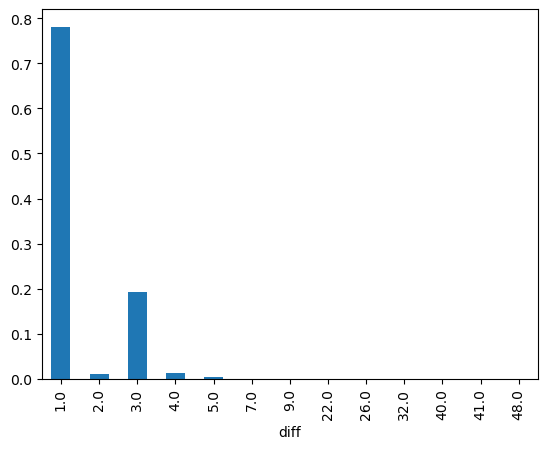

In [117]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [118]:
threshold = 2
(df['diff'] < 4).mean(), (df['diff'] < 5).mean()

(0.9823141518236238, 0.9955654334448091)

In [119]:
#Отлично

# -1. Акции под удаление

In [124]:
# 'DIOD',
# 'ROST',
# 'INGR', #их не видно в терминале

In [127]:
#Оставляем только акции, торгующиеся более 1.5 лет
need_days = int(365 * (5/7) * 1.5) 
need_days



391

In [128]:
#1hour
del_stocks_1hour = []

for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

    if df.shape[0] < need_days*14: #14 часов в торг сессии
        del_stocks_1hour += [stock]
        

100%|█████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 5422.34it/s]


In [129]:
len(del_stocks_1hour)

22

In [130]:
del_stocks_1hour

['DIOD',
 'ROST',
 'GECO',
 'MGKL',
 'KLVZ',
 'CARM',
 'ZAYM',
 'IVAT',
 'EUTR',
 'HNFG',
 'DELI',
 'SOFL',
 'DIAS',
 'MBNK',
 'INGR',
 'VSEH',
 'PRMD',
 'LEAS',
 'ELMT',
 'ASTR',
 'UGLD',
 'SVCB']

In [132]:
#1day
del_stocks_1day = []

for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

    if df.shape[0] < need_days: #14 часов в торг сессии
        del_stocks_1day += [stock]
        

100%|████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 16287.50it/s]


In [133]:
len(del_stocks_1day)

17

In [134]:
del_stocks_1day

['MGKL',
 'KLVZ',
 'ZAYM',
 'IVAT',
 'EUTR',
 'HNFG',
 'DELI',
 'SOFL',
 'DIAS',
 'MBNK',
 'VSEH',
 'PRMD',
 'LEAS',
 'ELMT',
 'ASTR',
 'UGLD',
 'SVCB']

In [136]:
#Union
del_stocks = set(del_stocks_1hour + del_stocks_1day)

In [137]:
len(del_stocks)

22

In [138]:
del_stocks

{'ASTR',
 'CARM',
 'DELI',
 'DIAS',
 'DIOD',
 'ELMT',
 'EUTR',
 'GECO',
 'HNFG',
 'INGR',
 'IVAT',
 'KLVZ',
 'LEAS',
 'MBNK',
 'MGKL',
 'PRMD',
 'ROST',
 'SOFL',
 'SVCB',
 'UGLD',
 'VSEH',
 'ZAYM'}

In [139]:
#delete
for stock in del_stocks:
    os.remove(f"./data/preproc/1hour/{stock}.pkl")
    os.remove(f"./data/preproc/1day/{stock}.pkl")

In [141]:
import os

In [142]:
[elem.split('.') [0] for elem in os.listdir('./data/preproc/1day/')]

['AFLT',
 'IRAO',
 'MVID',
 'OGKB',
 'SPBE',
 'MTLRP',
 'SFIN',
 'KMAZ',
 'CBOM',
 'MSNG',
 'FEES',
 'LKOH',
 'FESH',
 'KROT',
 'LENT',
 'MDMG',
 'NKNCP',
 'VKCO',
 'UPRO',
 'MRKY',
 'SELG',
 'SGZH',
 'AKRN',
 'CHMK',
 'ENPG',
 'YAKG',
 'PMSBP',
 'RKKE',
 'GEMC',
 'LSRG',
 'MRKZ',
 'BANE',
 'CNTL',
 'PMSB',
 'KRKNP',
 'NMTP',
 'PLZL',
 'TATN',
 'AFKS',
 'UNKL',
 'APTK',
 'LNZL',
 'GMKN',
 'NSVZ',
 'LIFE',
 'RNFT',
 'VRSB',
 'YDEX',
 'UWGN',
 'TGKN',
 'ABRD',
 'HYDR',
 'ABIO',
 'WUSH',
 'RTKMP',
 'GTRK',
 'NLMK',
 'TATNP',
 'CNTLP',
 'BLNG',
 'ALRS',
 'GCHE',
 'VSMO',
 'LSNG',
 'TRNFP',
 'MGNT',
 'RENI',
 'NKHP',
 'TGKB',
 'ROLO',
 'IRKT',
 'MGTSP',
 'MTLR',
 'TGKA',
 'MSRS',
 'HEAD',
 'RUAL',
 'MRKV',
 'KLSB',
 'SIBN',
 'SNGS',
 'MSTT',
 'KAZTP',
 'DVEC',
 'NVTK',
 'RASP',
 'VTBR',
 'PHOR',
 'TTLK',
 'NKNC',
 'T',
 'KAZT',
 'AMEZ',
 'MRKU',
 'TRMK',
 'MOEX',
 'SBERP',
 'VEON-RX',
 'CHMF',
 'RTKM',
 'SMLT',
 'LNZLP',
 'MRKC',
 'MRKP',
 'UNAC',
 'KZOSP',
 'GAZP',
 'ROSN',
 'BELU',
 'ELFV

### Поправим BELU после сплита

In [144]:
#1 day
stock = "BELU"
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

mask_open = df['time'] < pd.Timestamp('2024-08-23')
df.loc[mask_open, ['open', 'high']] = df.loc[mask_open, ['open', 'high']]/8
mask_close = df['time'] < pd.Timestamp('2024-08-22')
df.loc[mask_close, ['close', 'low']] = df.loc[mask_close, ['close', 'low']]/8

dump_pkl(df, f"./data/preproc/1day/{stock}.pkl")

In [145]:
#1 hour
df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

mask = df['time'] < pd.Timestamp('2024-08-22')
df.loc[mask, ['close', 'low', 'open', 'high']] = df.loc[mask, ['close', 'low', 'open', 'high']]/8

dump_pkl(df, f"./data/preproc/1hour/{stock}.pkl")

In [193]:
1

1

# -2. Check data

In [203]:
paths = os.listdir("./data/preproc/1hour/")
paths[17], paths[34]

('VKCO.pkl', 'KRKNP.pkl')

### -2.1 VKCO

In [207]:
#чекнуть сами данные и совпадение с индексом

In [209]:
#1hour
i = -124

stock = "VKCO"
df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df.iloc[i-1:i+1]

,time,open,close,volume,low,high,ticker,tmos_close
9000,2025-01-17 11:00:00,338.6,338.4,881662.0,337.2,340.6,VKCO,6.38
9001,2025-01-17 12:00:00,338.4,347.0,3655608.0,338.4,348.0,VKCO,6.38


In [230]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df.iloc[i-1:i+1]

,time,open,close,volume,low,high,ticker,tmos_close
542,2024-07-26 03:00:00,475.0,460.8,3858255.0,456.8,486.0,VKCO,6.35
543,2024-07-29 03:00:00,453.8,446.0,1776157.0,440.0,454.2,VKCO,6.21


### -2.2 KRKNP

In [234]:
#1hour
i = -78

stock = "KRKNP"
df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df.iloc[i-1:i+1]

,time,open,close,volume,low,high,ticker,tmos_close
6558,2025-01-15 19:00:00,8160.0,8140.0,4.0,8140.0,8160.0,KRKNP,6.28
6559,2025-01-15 20:00:00,8080.0,8080.0,1.0,8080.0,8080.0,KRKNP,6.29


In [236]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df.iloc[i-1:i+1]

,time,open,close,volume,low,high,ticker,tmos_close
611,2024-09-30 03:00:00,9140.0,9120.0,201.0,9080.0,9240.0,KRKNP,6.02
612,2024-10-01 03:00:00,9240.0,8880.0,1761.0,8720.0,9240.0,KRKNP,6.00


### -2.3 SNGS

In [240]:
#1hour
i = -32

stock = "SNGS"
df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df.iloc[i-1:i+1]

,time,open,close,volume,low,high,ticker,tmos_close
9355,2025-01-21 19:00:00,26.715,26.53,45436.0,26.50,26.745,SNGS,6.40
9356,2025-01-21 20:00:00,26.540,26.64,16927.0,26.52,26.655,SNGS,6.42


In [242]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df.iloc[i-1:i+1]

,time,open,close,volume,low,high,ticker,tmos_close
657,2024-12-04 03:00:00,23.615,22.810,454791.0,22.655,23.76,SNGS,5.29
658,2024-12-05 03:00:00,22.985,23.275,418466.0,22.500,23.41,SNGS,5.42


### TMP

In [195]:
#1hour
stock = "SNGS"
df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df

,time,open,close,volume,low,high,ticker,tmos_close
0,2022-05-04 10:00:00,23.730,23.520,10876.0,23.470,23.880,SNGS,4.27
1,2022-05-04 11:00:00,23.520,23.185,11712.0,23.055,23.645,SNGS,4.20
2,2022-05-04 12:00:00,23.240,23.360,4570.0,23.200,23.395,SNGS,4.22
3,2022-05-04 13:00:00,23.350,23.260,2361.0,23.260,23.400,SNGS,4.21
4,2022-05-04 14:00:00,23.265,23.310,1891.0,23.200,23.350,SNGS,4.21
...,...,...,...,...,...,...,...,...
9495,2025-02-04 19:00:00,27.695,27.655,3601.0,27.610,27.700,SNGS,6.40
9496,2025-02-04 20:00:00,27.655,27.635,7512.0,27.580,27.690,SNGS,6.39
9497,2025-02-04 21:00:00,27.635,27.560,11894.0,27.515,27.640,SNGS,6.36
9498,2025-02-04 22:00:00,27.565,27.640,10120.0,27.515,27.665,SNGS,6.38


In [199]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df

,time,open,close,volume,low,high,ticker,tmos_close
0,2022-05-04 03:00:00,23.710,23.055,41559.0,23.055,23.880,SNGS,4.18
1,2022-05-05 03:00:00,23.300,23.300,27736.0,23.080,23.485,SNGS,4.22
2,2022-05-06 03:00:00,23.125,23.920,95887.0,22.865,24.070,SNGS,4.19
3,2022-05-11 03:00:00,23.970,23.560,64940.0,23.315,23.970,SNGS,4.22
4,2022-05-12 03:00:00,23.560,22.550,60619.0,22.400,23.665,SNGS,4.06
...,...,...,...,...,...,...,...,...
693,2025-01-29 03:00:00,28.100,27.720,368400.0,27.585,28.200,SNGS,6.42
694,2025-01-30 03:00:00,27.690,27.895,364560.0,27.360,28.095,SNGS,6.49
695,2025-01-31 03:00:00,27.920,27.725,545784.0,27.325,28.450,SNGS,6.48
696,2025-02-03 03:00:00,27.570,27.955,371474.0,27.355,28.125,SNGS,6.45
